# Product Text Generation with Phi2 + LoRA

The model will generate product name and product description based on the input category.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd

df = pd.read_csv("datasets/amazon_product_details.csv")

In [4]:
df.columns

Index(['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'rating_count',
       'about_product', 'user_id', 'user_name', 'review_id', 'review_title',
       'review_content', 'img_link', 'product_link'],
      dtype='object')

In [5]:
# We only use three columns: product name, description, category
df = df.loc[:, ['product_name', 'category', 'about_product']]
df.head()

,product_name,category,about_product
0,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,High Compatibility : Compatible With iPhone 12...
1,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,"Compatible with all Type C enabled devices, be..."
2,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,【 Fast Charger& Data Sync】-With built-in safet...
3,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,The boAt Deuce USB 300 2 in 1 cable is compati...
4,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,[CHARGE & SYNC FUNCTION]- This cable comes wit...


## Data preprocessing

In [6]:
# We want to extract only one category from the category column, we split it and we take the last el
df['category'] = df['category'].apply(lambda x: x.split('|')[-1])
df['category'].value_counts()

category
USBCables               233
SmartWatches             76
Smartphones              68
SmartTelevisions         63
In-Ear                   52
                       ... 
RotiMakers                1
FanParts&Accessories      1
StandMixers               1
PedestalFans              1
HandheldBags              1
Name: count, Length: 207, dtype: int64

In [7]:
# We want to change the dataset to be category, text, task type
# The text will be the product name and product description
# The task type will be the type of text: product name / product description

products = df[['category', 'product_name']].rename(columns={'product_name': 'text'})
descriptions = df[['category', 'about_product']].rename(columns={'about_product': 'text'})

products['task_type'] = "Product Name"
descriptions['task_type'] = "Product Description"

df = pd.concat([products, descriptions])
df

,category,text,task_type
0,USBCables,Wayona Nylon Braided USB to Lightning Fast Cha...,Product Name
1,USBCables,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Product Name
2,USBCables,Sounce Fast Phone Charging Cable & Data Sync U...,Product Name
3,USBCables,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Product Name
4,USBCables,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Product Name
...,...,...,...
1460,WaterPurifierAccessories,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,Product Description
1461,Rice&PastaCookers,"230 Volts, 400 watts, 1 Year",Product Description
1462,HeatConvectors,International design and styling|Two heat sett...,Product Description
1463,ExhaustFans,Fan sweep area: 230 MM ; Noise level: (40 - 45...,Product Description


## Dataset analysis
We use histogram to find suitable maximum token length to fasten the finetuning process. Assume each word equal to 1.5 tokens.

In [8]:
products['text_len'] = products['text'].apply(lambda x: len(x.split()) * 1.5)
descriptions['text_len'] = descriptions['text'].apply(lambda x: len(x.split()) * 1.5)

In [9]:
import matplotlib.pyplot as plt

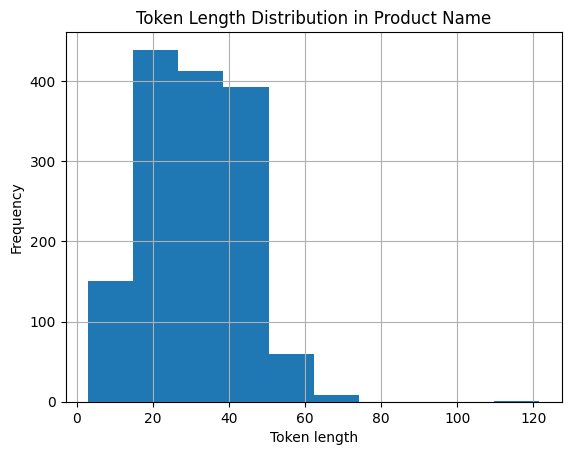

In [10]:
products.hist()
plt.title('Token Length Distribution in Product Name')
plt.xlabel('Token length')
plt.ylabel('Frequency')
plt.show()

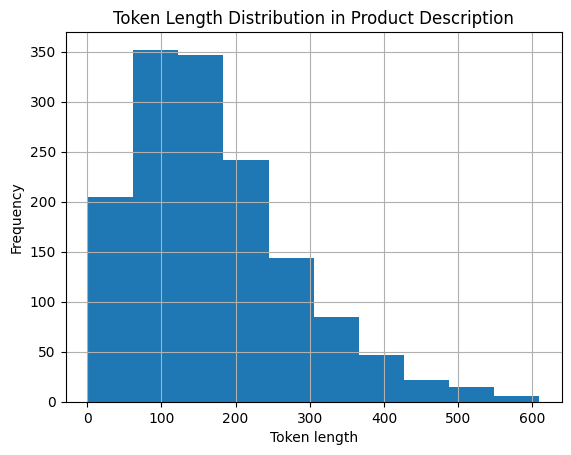

In [11]:
descriptions.hist()
plt.title('Token Length Distribution in Product Description')
plt.xlabel('Token length')
plt.ylabel('Frequency')
plt.show()

It is right to set 400 as the maximum token input length.

## Split dataset

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
val, test = train_test_split(test, test_size=0.5, random_state=42)

train.shape, val.shape, test.shape

((2344, 3), (293, 3), (293, 3))

In [14]:
from datasets import Dataset, DatasetDict

In [15]:
dataset = DatasetDict(
    {
        'train': Dataset.from_pandas(train, preserve_index=False),
        'validation': Dataset.from_pandas(val, preserve_index=False),
        'test': Dataset.from_pandas(test, preserve_index=False),
    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['category', 'text', 'task_type'],
        num_rows: 2344
    })
    validation: Dataset({
        features: ['category', 'text', 'task_type'],
        num_rows: 293
    })
    test: Dataset({
        features: ['category', 'text', 'task_type'],
        num_rows: 293
    })
})

In [16]:
dataset['train'][100]

{'category': 'In-Ear',
 'text': 'Boult Audio FXCharge with ENC, 32H Playtime, 5min=7H Type C Fast Charging, Zen ENC, 14.2 mm BoomX Rich Bass, IPX5, Bluetooth Wireless in Ear Earphones Neckband with mic (Black)',
 'task_type': 'Product Name'}

In [17]:
def formatting(example):
    text = f"""
Given the product category, you need to generate a '{example['task_type']}'.
### Category: {example['category']}
### {example['task_type']}: {example['text']}
"""
    return text

In [18]:
print(formatting(dataset['train'][0]))


Given the product category, you need to generate a 'Product Name'.
### Category: Smartphones
### Product Name: Redmi 10A (Slate Grey, 4GB RAM, 64GB Storage) | 2 Ghz Octa Core Helio G25 | 5000 mAh Battery | Finger Print Sensor | Upto 5GB RAM with RAM Booster



In [19]:
from datasets import Dataset, DatasetDict

In [20]:
dataset = DatasetDict(
    {
        "train": Dataset.from_pandas(train, preserve_index=False),
        "val": Dataset.from_pandas(val, preserve_index=False),
        "test": Dataset.from_pandas(test, preserve_index=False),
    }
)

In [21]:
dataset

DatasetDict({
    train: Dataset({
        features: ['category', 'text', 'task_type'],
        num_rows: 2344
    })
    val: Dataset({
        features: ['category', 'text', 'task_type'],
        num_rows: 293
    })
    test: Dataset({
        features: ['category', 'text', 'task_type'],
        num_rows: 293
    })
})

In [22]:
dataset['test'][2]

{'category': 'Cradles',
 'text': 'WeCool C1 Car Mobile Holder with One Click Technology,360° Rotational, Strong Suction Cup,Compatible with 4 to 6 Inch Devices, Wildshield and Dashboard Mobile Holder for Car, and Use',
 'task_type': 'Product Name'}

## Data formatting

In [23]:
# We format the input as below so that the model can understand the instruction
def formatting(example):
    text = f"""
Given the product category, you need to generate a '{example['task_type']}'.
### Category: {example['category']} 
### {example['task_type']}: {example['text']}
"""
    return text

In [24]:
print(formatting(dataset['train'][0]))


Given the product category, you need to generate a 'Product Name'.
### Category: Smartphones 
### Product Name: Redmi 10A (Slate Grey, 4GB RAM, 64GB Storage) | 2 Ghz Octa Core Helio G25 | 5000 mAh Battery | Finger Print Sensor | Upto 5GB RAM with RAM Booster



## Load base model and tokenizer

In [25]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
from transformers import AutoModelForCausalLM

model_ckpt = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(model_ckpt,
                                            trust_remote_code=True,
                                            torch_dtype=torch.float16,
                                            ).to(device)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 15.32it/s]


In [27]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_ckpt,
                                         padding_size='left',
                                         add_bos=True,
                                         add_eos=True,
                                         use_fast=False)

tokenizer.pad_token = tokenizer.eos_token

In [28]:
max_length = 400

In [29]:
def tokenize(prompt):
    result = tokenizer(formatting(prompt), 
                       max_length=max_length, 
                       padding='max_length', 
                       truncation=True
                      )
    result['labels'] = result['input_ids'].copy()
    return result

In [30]:
tokenize(dataset['train'][0])

{'input_ids': [198, 15056, 262, 1720, 6536, 11, 345, 761, 284, 7716, 257, 705, 15667, 6530, 4458, 198, 21017, 21743, 25, 10880, 9708, 220, 198, 21017, 8721, 6530, 25, 2297, 11632, 838, 32, 357, 11122, 378, 13980, 11, 604, 4579, 13931, 11, 5598, 4579, 20514, 8, 930, 362, 11972, 89, 2556, 64, 7231, 5053, 952, 402, 1495, 930, 23336, 285, 10910, 23490, 930, 39454, 12578, 35367, 930, 471, 457, 78, 642, 4579, 13931, 351, 13931, 35203, 198, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50

In [31]:
dataset_tokenized = dataset.map(tokenize)

Map: 100%|██████████| 293/293 [00:00<00:00, 541.35 examples/s]


## Try base model before finetuned

In [32]:
example_prompt = """
Given the product category, you need to generate a 'Product Name'.
### Category: Smartphones
### Product Name:
"""

In [33]:
# tokenize -> generate -> decode
# Tokenize
model_input = tokenizer(
    example_prompt,
    truncation = True,
    max_length=max_length,
    padding = "max_length",
    return_tensors='pt'
).to(device)

model.eval()
with torch.no_grad():
    # Generate
    output = model.generate(**model_input,
                           max_new_tokens=256,
                           repetition_penalty=1.15)
    # Decode
    result = tokenizer.decode(output[0], skip_special_tokens=True)
    print(result)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Given the product category, you need to generate a 'Product Name'.
### Category: Smartphones
### Product Name:
# Output: 
## Product Name: XYZ Smartphone



Surprisingly the model is already good?

## LoRA config

In [34]:
from peft import LoraConfig, get_peft_model

In [35]:
config = LoraConfig(
    r=64,
    lora_alpha=64,
    target_modules=["Wqkv", "fc1", "fc2"],
    bias="none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM"
)

In [36]:
model = get_peft_model(model, config)

In [37]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"Trainable params: {trainable_params} || All params: {all_param} || % Trainable: {(100 * trainable_params / all_param):.4f}")

In [38]:
print_trainable_parameters(model)

Trainable params: 52428800 || All params: 2832112640 || % Trainable: 1.8512


## Model training

In [39]:
from accelerate import Accelerator

accelerator = Accelerator(gradient_accumulation_steps=1)

model = accelerator.prepare_model(model)

In [40]:
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

In [41]:
args = TrainingArguments(
    output_dir="train_dir",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=1,
    max_steps=1000,
    learning_rate=5e-5, 
    logging_steps=25,              # When to start reporting loss
    logging_dir="./logs",          # Directory for storing logs
    save_strategy="steps",         # Save the model checkpoint every logging step
    save_steps=200,                 # Save checkpoints every 50 steps
    eval_strategy="steps",   # Evaluate the model every logging step
    eval_steps=200,                 # Evaluate and save checkpoints every 50 steps
    do_eval=True,                  # Perform evaluation at the end of training
)

In [42]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset_tokenized['train'],
    eval_dataset=dataset_tokenized['val'],
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [43]:
model.config.use_cache = False 
trainer.train()

Step,Training Loss,Validation Loss
200,2.621900,2.731203
400,2.586200,2.684880
600,2.663200,2.635527
800,2.492400,2.637958
1000,2.589600,2.631725


TrainOutput(global_step=1000, training_loss=2.6788897361755373, metrics={'train_runtime': 384.8304, 'train_samples_per_second': 5.197, 'train_steps_per_second': 2.599, 'total_flos': 1.2964995072e+16, 'train_loss': 2.6788897361755373, 'epoch': 0.8532423208191127})

## Load saved model and inference

In [44]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [45]:
from transformers import AutoModelForCausalLM

model_ckpt = "microsoft/phi-2"
base_model = AutoModelForCausalLM.from_pretrained(model_ckpt,
                                            trust_remote_code=True,
                                            torch_dtype=torch.float16,
                                            ).to(device)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 15.14it/s]


In [46]:
from transformers import AutoTokenizer

eval_tokenizer = AutoTokenizer.from_pretrained(model_ckpt,
                                         padding_size='left',
                                         add_bos=True,
                                         add_eos=True,
                                         use_fast=False)

eval_tokenizer.pad_token = tokenizer.eos_token

In [47]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, './train_dir/checkpoint-1000')

In [48]:
eval_prompt = """
Given the product category, you need to generate a 'Product Name'.
### Category: Smartphones
### Product Name:
"""

# tokenize -> generate -> decode
# Tokenize
model_input = eval_tokenizer(
    eval_prompt,
    return_tensors='pt'
).to(device)

ft_model.eval()
with torch.no_grad():
    # Generate
    output = ft_model.generate(**model_input,
                               max_new_tokens=256,
                               repetition_penalty=1.15)
    # Decode
    result = eval_tokenizer.decode(output[0], skip_special_tokens=True)
    print(result)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Given the product category, you need to generate a 'Product Name'.
### Category: Smartphones
### Product Name:
### Samsung Galaxy S21 Ultra (5G) | 64GB RAM| 12GB Storage 
### Product Description:
### The Samsung Galaxy S21 Ultra is packed with premium features and cutting-edge technology. It boasts an impressive 5G connectivity for lightning fast internet speeds. With its 64GB RAM, it can handle multitasking like never before. And thanks to its 12GB storage, you'll have plenty of space to store all your favorite apps, photos, videos, and more.
### Product Features:
### - 6.8 inches Dynamic AMOLED 2200 x 1080 pixels display
### - 108MP camera with 8GB AI memory card
### - 5000mAh battery that supports wireless charging & reverse wireless charging
### - In-display fingerprint scanner for added security
### Product Specifications:
### - Processor: Exynos 2100 (10nm)
### - GPU: Adreno 620 (12GB TPU)
### - Storage: 128GB/256GB/512GB/1TB/2TB/4TB/6TB/8GB/16GB/32GB/64GB/128GB/256GB/512GB/1024